# Regression - The Capital Bikeshare Dataset 

### Imports 

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np 

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_log_error

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures

from sklearn.compose import ColumnTransformer 

### Loading, Preparing Data and Exploratory Data Analysis 

In [2]:
df = pd.read_csv("Data/data.csv")

In [3]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
df.shape

(10886, 12)

In [5]:
df.isna().values.any()

False

no missing values 

In [6]:
df["datetime"].dtype

dtype('O')

Convert the data in the datetime column into datetime format (original datatype: object)

In [7]:
df["datetime"] = pd.to_datetime(df["datetime"]) 

In [8]:
df["datetime"].dtype

dtype('<M8[ns]')

Successfully converted! 

In [9]:
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['weekday'] = df['datetime'].dt.weekday
df['hour'] = df['datetime'].dt.hour

In [10]:
df.shape

(10886, 17)

For simplicity's sake, let 0 represent 2011 and 1 represent 2012 

In [11]:
df.loc[df["year"]==2011,"year"] = 0 
df.loc[df["year"]==2012,"year"] = 1 

In [12]:
df["year"].value_counts()

1    5464
0    5422
Name: year, dtype: int64

#### Train-Test-Split

In [13]:
y = df["count"] 
X = df.drop(["casual","count","registered","datetime"],axis=1) 

In [14]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.25, random_state = 1) 
X_train.shape, X_test.shape,y_train.shape,y_test.shape

((8164, 13), (2722, 13), (8164,), (2722,))

#### Exploratory Data Analysis 

Create a seperate dataframe for the exploratory data analysis, just to be tidy!

In [15]:
df_exploration = df 

In [16]:
df_exploration.set_index("datetime",inplace=True) #needed for the resampling method

In [17]:
df_exploration["count"].groupby(df_exploration["year"]).sum()

year
0     781979
1    1303497
Name: count, dtype: int64

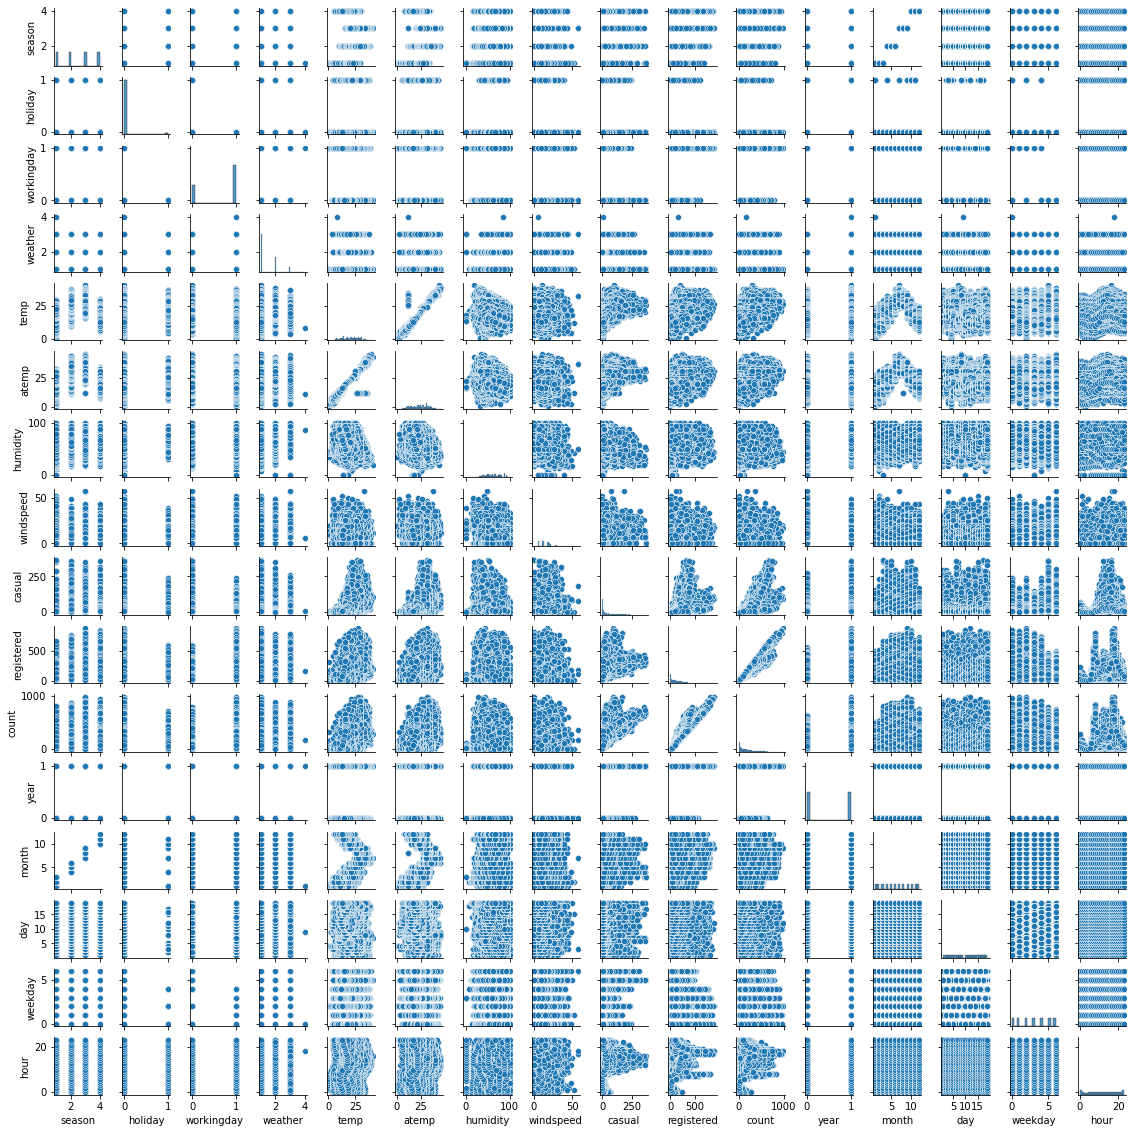

In [18]:
sns.pairplot(df_exploration,height=1);


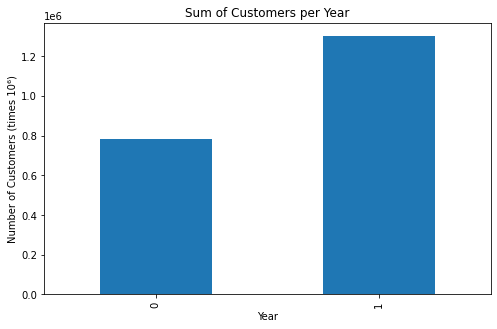

In [19]:
df_exploration["count"].groupby(df_exploration["year"]).sum().plot.bar(figsize=(8,5),
                                                                      title="Sum of Customers per Year",
                                                                      xlabel="Year",
                                                                      ylabel= "Number of Customers (times 10⁶)");

**Takeaway**: There has been a huge increase of customers from 2011 to 2012 

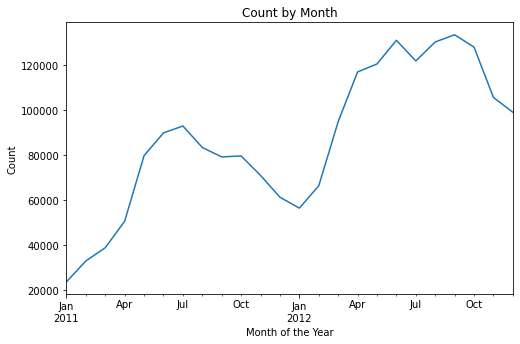

In [20]:
df_exploration.resample('M')["count"].sum().plot(figsize=(8,5),
                                                 xlabel="Month of the Year",
                                                 ylabel="Count",title="Count by Month");

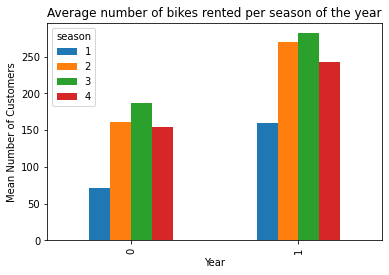

In [21]:

df.groupby(['year', 'season'])['count'].mean().unstack().plot.bar(title="Average number of bikes rented per season of the year",
                                                                 xlabel="Year",
                                                                 ylabel="Mean Number of Customers");


**Takeaway**: The number of customers continously increase until about July and then drop

Get some **statistical data**:

In [22]:
df_exploration.loc[df_exploration["year"]==0,"count"].resample("M").sum().describe()

count       12.000000
mean     65164.916667
std      23453.754417
min      23552.000000
25%      47571.500000
50%      74996.500000
75%      80608.750000
max      92848.000000
Name: count, dtype: float64

In [23]:
df_exploration.loc[df_exploration["year"]==1,"count"].resample("M").sum().describe()

count        12.000000
mean     108624.750000
std       25505.310107
min       56332.000000
25%       97924.250000
50%      118659.500000
75%      128489.000000
max      133425.000000
Name: count, dtype: float64

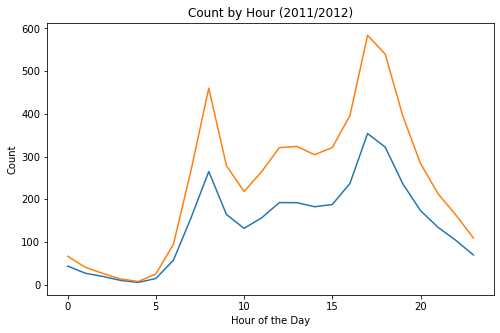

In [24]:
filt_2011 = (df_exploration.index.year == 2011)
filt_2012 = (df_exploration.index.year == 2012)

df_plot_2011 = df_exploration[filt_2011] 
df_plot_2011["count"].groupby(df_plot_2011.index.hour).mean().plot(figsize=(8,5),xlabel="Hour of the Day",ylabel="Count",title="Count by Hour (2011/2012)")

df_plot_2012 = df_exploration[filt_2012] 
df_plot_2012["count"].groupby(df_plot_2012.index.hour).mean().plot(figsize=(8,5),xlabel="Hour of the Day",ylabel="Count");

**Takeaway**: No matter the year, there are two clear peakes of usage, one around 8 a.m and the other around 4 p.m (work commute) 

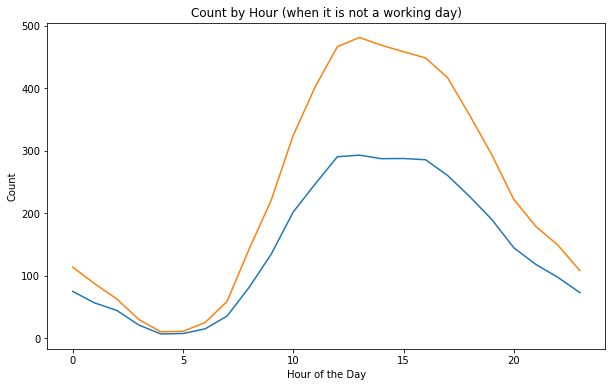

In [25]:
filt_2011 = (df_exploration.index.year == 2011) & (df_exploration.workingday == 0) 
filt_2012 = (df_exploration.index.year == 2012) & (df_exploration.workingday == 0) 

df_plot_2011 = df_exploration[filt_2011] 
df_plot_2011["count"].groupby(df_plot_2011.index.hour).mean().plot(figsize=(10,6),xlabel="Hour of the Day",
                                                                   ylabel="Count",
                                                                   title="Count by Hour (when it is not a working day)")

df_plot_2012 = df_exploration[filt_2012] 
df_plot_2012["count"].groupby(df_plot_2012.index.hour).mean().plot(figsize=(10,6),
                                                                   xlabel="Hour of the Day",
                                                                   ylabel="Count");

**Takeaway**: The pattern above does not hold when it's not a working day! 

Let's look further into the difference between working days and non-working days! 

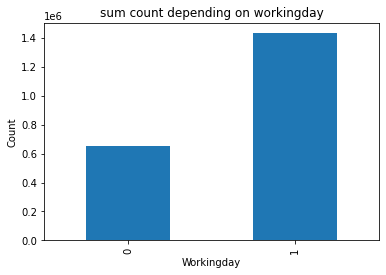

In [26]:
df_exploration["count"].groupby(df_exploration["workingday"]).sum().plot.bar(ylabel="Count",xlabel="Workingday",title="sum count depending on workingday");                                       

**Takeaway**: People use the service more often on working days, no surprise here, but the difference is pretty huge! 

Let's look at the impact of **weather conditions**! 

Firstly, let's look at the weather data itself 

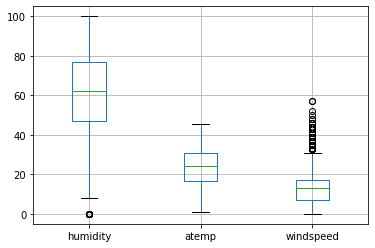

In [27]:
df_exploration[["humidity","atemp","windspeed"]].boxplot();

**Takeaway**: There are many outliers when it comes to windspeed, meaning it is usually not so windy but sometimes the wind blows strongly!

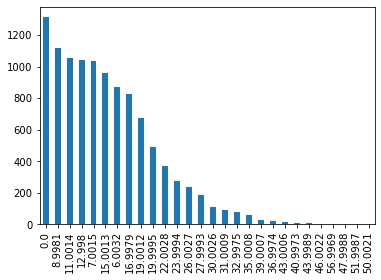

In [28]:
df_exploration["windspeed"].value_counts().plot.bar();

**Note**: So many days without any wind blowing tilt the average thus creating many outliers, this could lead to some issues for our model 

In [29]:
df_exploration["windspeed"].describe()

count    10886.000000
mean        12.799395
std          8.164537
min          0.000000
25%          7.001500
50%         12.998000
75%         16.997900
max         56.996900
Name: windspeed, dtype: float64

But now let's actually look at the impact of the weather conditions! 

In [30]:
df_exploration.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count', 'year',
       'month', 'day', 'weekday', 'hour'],
      dtype='object')

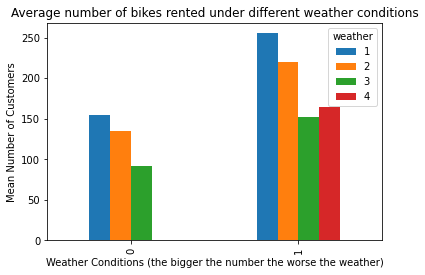

In [31]:
df_exploration.groupby(['year', 'weather'])['count'].mean().unstack().plot.bar(title="Average number of bikes rented under different weather conditions",
                                                                 xlabel="Weather Conditions (the bigger the number the worse the weather)",
                                                                 ylabel="Mean Number of Customers");

In [32]:
df_exploration["weather"].value_counts()

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

Let's merge category 4 with category 3 (in the original df) 

In [33]:
df["weather"] = df["weather"].replace(4,3)
df_exploration["weather"].value_counts()

1    7192
2    2834
3     860
Name: weather, dtype: int64

Now, let's look at the **temperature**!

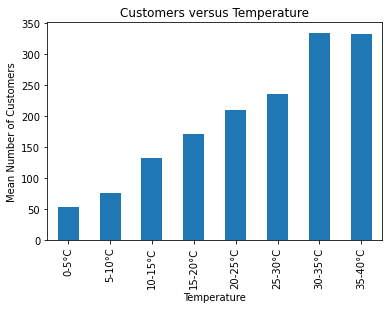

In [34]:
labels = ['0-5°C', '5-10°C', '10-15°C', '15-20°C', '20-25°C', '25-30°C', '30-35°C', '35-40°C']
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40]
df.groupby(pd.cut(df['temp'], bins, labels=labels))['count'].mean().plot.bar(xlabel="Temperature",ylabel="Mean Number of Customers", title="Customers versus Temperature"); 

Finally, let's look at the **windspeed**

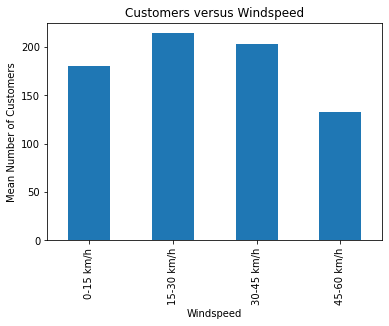

In [35]:
labels = ['0-15 km/h', '15-30 km/h', '30-45 km/h', '45-60 km/h']
bins = [0, 15, 30, 45, 60]
df.groupby(pd.cut(df['windspeed'], bins, labels=labels))['count'].mean().plot.bar(xlabel="Windspeed",ylabel="Mean Number of Customers",title="Customers versus Windspeed");

For future feature engineering, let's check for highly correlated features with a heatmap! (now we use the train dataframe!) 

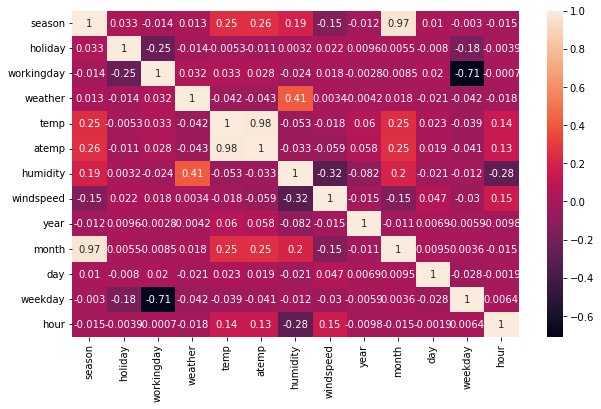

In [36]:
plt.figure(figsize=(10,6))
sns.heatmap(X_train.corr(),annot=True);

**Takeaway**: temp and atemp are, obviously, highly correlated, we can drop one. There are some other, rather obvious, high correlations (e.g. between day_of_week and workingday), let's decide later which to drop. 

In [37]:
X_train.drop("atemp",axis=1,inplace=True)
X_test.drop("atemp",axis=1,inplace=True) 

### Build a basic model (baseline model) with only very basic preprocessing 

In [38]:
feature_transform = ColumnTransformer([
    ('one_hot_encoder', OneHotEncoder(handle_unknown = "ignore", sparse = True), ['season',"weather","month"]),
    ('num_preprocessing', MinMaxScaler(), ["temp","humidity"]),
    ("binning_windspeed",KBinsDiscretizer(n_bins= 3, strategy = 'uniform', encode = 'onehot-dense'),["windspeed"]),
    ("binning_hours", KBinsDiscretizer(n_bins= 4, strategy = 'uniform', encode = 'onehot-dense'),["hour"]), 
    ("no_transform","passthrough",["holiday","workingday","year","weekday"]),
])

In [39]:
X_train_trans = feature_transform.fit_transform(X_train) 

##### Linear Regression Model 

In [40]:
X_train_trans.shape

(8164, 33)

In [41]:
y_train.shape

(8164,)

In [42]:
lrm = LinearRegression()

In [43]:
lrm.fit(X_train_trans,y_train) 

LinearRegression()

**The Score**:

In [44]:
round(lrm.score(X_train_trans, y_train),3)

0.502

Pretty bad, but that's expected 

Now on the test set 

In [45]:
X_test_trans = feature_transform.transform(X_test) 

In [46]:
round(lrm.score(X_test_trans, y_test),3)

0.504

##### Random Forest Regressor

In [47]:
rfr = RandomForestRegressor() 
rfr.fit(X_train_trans,y_train)
round(rfr.score(X_train_trans, y_train),3)


0.922

In [48]:
round(rfr.score(X_test_trans, y_test),3)

0.615

**Note**: The Random Forest Regressor seems promiseful, but still, this obviously isn't a good result, it's just better. Also this simple random forest regressor model is clearly **overfitting**

### Feature Engineering, Preprocessing and Transforming

#### Incorporate the **cyclical nature of time** into our model

For more information: https://www.kaggle.com/code/avanwyk/encoding-cyclical-features-for-deep-learning/notebook 

**Remark** : "ctf" is my abbreviation for  "cyclical_time_feature" 

In [49]:
def ctf_generator(pds, cycle):
    #Thanks to : https://www.kaggle.com/code/avanwyk/encoding-cyclical-features-for-deep-learning/notebook
    df = pd.DataFrame(
        {pds.name + "_sin" : np.sin(2 * np.pi * pds/cycle),
         pds.name + "_cos" : np.cos(2 * np.pi * pds/cycle)}
    )

    return df

#### Preprocessing and Transforming

Creating custom FunctionTransformers to generate cyclical time features (but only for the hours and the month) 

In [50]:
hour_cyclical = FunctionTransformer(ctf_generator, kw_args={'cycle' : 24})
month_cyclical = FunctionTransformer(ctf_generator, kw_args={'cycle' : 12})

**Creating Pipelines**

For the simple numerical features, we simply use a scaler! 

In [51]:
num_pipe = make_pipeline(
    MinMaxScaler())

Since a simple **linear** regression probably won't due we introduce some polynomial features (pf) to our model! 

In [52]:
pf_pipe = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(degree=5,include_bias=False))

For the categorical features, we simply use one hot encoding

In [53]:
cat_pipe = make_pipeline(
    OneHotEncoder(handle_unknown="ignore"))

Create **interaction terms** (compare EDA) 

In [54]:
X_train.loc[X_train.index, 'hour_workingday'] = (X_train.loc[X_train.index, "hour"] * X_train.loc[X_train.index, "workingday"])
X_test.loc[X_test.index, 'hour_workingday'] = (X_test.loc[X_test.index, "hour"] * X_test.loc[X_test.index, "workingday"])
X.loc[X.index, 'hour_workingday'] = (X.loc[X.index, "hour"] * X.loc[X.index, "workingday"])

In [55]:
X_train.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'humidity',
       'windspeed', 'year', 'month', 'day', 'weekday', 'hour',
       'hour_workingday'],
      dtype='object')

In [56]:
X_train.head()

,season,holiday,workingday,weather,temp,humidity,windspeed,year,month,day,weekday,hour,hour_workingday
9639,4,0,0,1,22.96,83,11.0014,1,10,6,5,0,0
7284,2,0,1,1,21.32,77,15.0013,1,5,2,2,21,21
10463,4,0,0,2,11.48,93,11.0014,1,12,2,6,9,0
3079,3,0,0,1,26.24,69,15.0013,0,7,17,6,5,0
5630,1,0,1,3,9.02,87,0.0000,1,1,9,0,17,17


In [57]:
feature_transform_m1= ColumnTransformer(transformers=[
    ('do_nothing', 'passthrough', ['year', 'holiday',"workingday"]), #no need to one hot encode boolean values 
    ('cat_prep', cat_pipe, ['hour', 'month', 'weather', 'weekday','season']),
    ('poly_prep', pf_pipe, ['temp', 'windspeed', 'humidity'])
])

The problem with this approach is related to the so-called **"curse of dimensionality"** since the cat_pipe does all the heavy lifting the dimensionality of the dataset increases. I still think it'll be alright because the dataset isn't so big 

In [58]:
feature_transform_m2 = ColumnTransformer(transformers=[
    ('do_nothing', 'passthrough', ['year', 'holiday',"workingday"]),
    ('cat_prep', cat_pipe, ['hour', 'month', 'weather', 'weekday','season']),
    ("binning",KBinsDiscretizer(n_bins= 3, strategy = 'uniform', encode = 'onehot-dense'),["windspeed"]),
    ('poly_prep', pf_pipe, ['temp', 'humidity'])
])

Binning windspeed should help with the outliers 

In [59]:
feature_transform_m3 = ColumnTransformer(transformers=[
    ('do_nothing', 'passthrough', ['year', 'holiday',"workingday"]),
    ('cat_prep', cat_pipe, ['weather', 'weekday','season']),
    ('ctf_month',month_cyclical,'month'),
    ('ctf_hour',hour_cyclical,'hour'),
    ("binning",KBinsDiscretizer(n_bins= 3, strategy = 'uniform', encode = 'onehot-dense'),["windspeed"]),
    ('poly_prep', pf_pipe, ['temp', 'humidity'])])

using cyclical time features! 

### Creating models and assessing accuracy!

#### Model 1a : RFR

In [60]:
X_train_m1, X_test_m1,y_train_m1,y_test_m1 = X_train,X_test,y_train,y_test #create copys for every model just to be tidy 

In [61]:
X_train_m1_trans = feature_transform_m1.fit_transform(X_train_m1)
X_test_m1_trans  = feature_transform_m1.transform(X_test_m1)

In [62]:
rfr_m1 = RandomForestRegressor(max_depth=6,random_state=1) 

In [63]:
rfr_m1.fit(X_train_m1_trans,y_train_m1)

RandomForestRegressor(max_depth=6, random_state=1)

In [64]:
print("Accuracy based on training data:", round(rfr_m1.score(X_train_m1_trans, y_train_m1), 3))

Accuracy based on training data: 0.611


In [65]:
print("Accuracy based on test data:", round(rfr_m1.score(X_test_m1_trans, y_test_m1), 3))

Accuracy based on test data: 0.606


#### Model 1b : LR

In [66]:
lr_m1 = LinearRegression()

In [67]:
lr_m1.fit(X_train_m1_trans,y_train_m1)

LinearRegression()

In [68]:
print("Accuracy based on training data:", round(lr_m1.score(X_train_m1_trans, y_train_m1), 3))

Accuracy based on training data: 0.713


In [69]:
print("Accuracy based on test data:", round(lr_m1.score(X_test_m1_trans, y_test_m1), 3))

Accuracy based on test data: 0.709


**Conclusion**: Increase in the accuracy of the linear regression model, the random forest regression model performs even worse! 

**Kfold crossvalidation** for the linear regression model

In [70]:
X_m1 = feature_transform_m1.fit_transform(X)

In [71]:
lr_m1_cv = LinearRegression()
lr_m1_cv.fit(X_m1, y)

LinearRegression()

In [72]:
cv = KFold(n_splits=5, shuffle=True, random_state=3)

cv_result_m1 = cross_val_score(
    estimator=lr_m1_cv, 
    X=X_m1,
    y=y,
    scoring='r2',
    cv=cv, 
    verbose=5
)

[CV] END ................................ score: (test=0.703) total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


[CV] END .......... score: (test=-8932024256346256834560.000) total time=   0.1s
[CV] END ................................ score: (test=0.691) total time=   0.0s
[CV] END ................................ score: (test=0.705) total time=   0.0s
[CV] END ................................ score: (test=0.711) total time=   0.1s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished


In [73]:
print(f'Validation r2 scores:\n{np.round(cv_result_m1,2)}')
print(f'\nmean: {cv_result_m1.mean():.3}')
print(f'std: {cv_result_m1.std():.2}')

Validation r2 scores:
[ 7.00000000e-01 -8.93202426e+21  6.90000000e-01  7.10000000e-01
  7.10000000e-01]

mean: -1.79e+21
std: 3.6e+21


**Note**: Usually the acuracy hovers around 70, but there is one big outlier (the second entry, not quite sure what to do about that

#### Model 2a : RFR

In [74]:
X_train_m2, X_test_m2,y_train_m2,y_test_m2 = X_train,X_test,y_train,y_test 

In [75]:
X_train_m2_trans = feature_transform_m2.fit_transform(X_train_m2)
X_test_m2_trans  = feature_transform_m2.transform(X_test_m2)

In [76]:
rfr_m2 = RandomForestRegressor(max_depth=6,random_state=1) 

In [77]:
rfr_m2.fit(X_train_m2_trans,y_train_m2)

RandomForestRegressor(max_depth=6, random_state=1)

In [78]:
print("Accuracy based on training data:", round(rfr_m2.score(X_train_m2_trans, y_train_m2), 3))
print("Accuracy based on test data:", round(rfr_m2.score(X_test_m2_trans, y_test_m2), 3))

Accuracy based on training data: 0.638
Accuracy based on test data: 0.636


**Note**: Slight increase in accuracy 

#### Model 2b : LR

In [79]:
lr_m2 = LinearRegression()
lr_m2.fit(X_train_m2_trans,y_train_m2)
print("Accuracy based on training data:", round(lr_m2.score(X_train_m2_trans, y_train_m2), 3))
print("Accuracy based on test data:", round(lr_m2.score(X_test_m2_trans, y_test_m2), 3))

Accuracy based on training data: 0.713
Accuracy based on test data: 0.712


**Note**: Nothing much changed 

#### Model 3a : RFR

In [82]:
X_train_m3, X_test_m3,y_train_m3,y_test_m3 = X_train,X_test,y_train,y_test 
X_train_m3_trans = feature_transform_m3.fit_transform(X_train_m3)
X_test_m3_trans  = feature_transform_m3.transform(X_test_m3)
rfr_m3 = RandomForestRegressor(max_depth=6,random_state=1) 
rfr_m3.fit(X_train_m3_trans,y_train_m3)
print("Accuracy based on training data:", round(rfr_m3.score(X_train_m3_trans, y_train_m3), 3))
print("Accuracy based on test data:", round(rfr_m3.score(X_test_m3_trans, y_test_m3), 3))

Accuracy based on training data: 0.798
Accuracy based on test data: 0.79


**Note**: Pretty big increase in accuracy, probably the best I can do for now!

#### Model 3b : LR

In [83]:
lr_m3 = LinearRegression()
lr_m3.fit(X_train_m3_trans,y_train_m3)
print("Accuracy based on training data:", round(lr_m3.score(X_train_m3_trans, y_train_m3), 3))
print("Accuracy based on test data:", round(lr_m3.score(X_test_m3_trans, y_test_m3), 3))

Accuracy based on training data: 0.517
Accuracy based on test data: 0.519


**Note**: Way worse for the linear regression model